In [19]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 5.5)

In [20]:
def dist_to_ferry(lat,lon):
    ferry = (37.795623,-122.393439)
    result = (lat-ferry[0])*(lat-ferry[0])+(lon-ferry[1])*(lon-ferry[1])
    return math.sqrt(result)

In [24]:
#read and transform dataset
df = pd.read_csv('data/SF_data_private_2.csv',delimiter=';');
df=df.dropna();
df=df.drop('page',1)
df=df[df.price<500]
df['bed_type'].unique()

array(['Futon', 'Real Bed', 'Airbed', 'Pull-out Sofa', 'Couch'], dtype=object)

In [31]:
df['log_dist_ferry']=df.apply(lambda x:math.log(1/dist_to_ferry(x['lat'],x['lon'])),axis=1)
df['bed_futon'] = df['bed_type'].apply(lambda x: x=='Futon')
df['bed_real'] = df['bed_type'].apply(lambda x: x=='Real Bed')
df['bed_air'] = df['bed_type'].apply(lambda x: x=='Airbed')
df['bed_sofa'] = df['bed_type'].apply(lambda x:x=='Pull-out Sofa')
df['bed_couch'] = df['bed_type'].apply(lambda x: x=='Couch')

In [37]:
df['room_type'].unique()
df['private_room'] = df['room_type'].apply(lambda x: x=='Private room')
df['entire_home'] = df['room_type'].apply(lambda x: x=='Entire home/apt')
#add the other option

In [38]:
#Number of training samples
M_train = int(len(df.index)*0.75)

#Randomly sample training set.
train_rows = np.random.choice(df.index.values,M_train)
df_train = df.ix[train_rows]
df_test = df.drop(train_rows)

print('M_train = %i, M_test = %i' % (M_train,len(df.index)-M_train))
#df.plot.scatter(x='lon',y='lat',c=df['price']/25);

M_train = 1310, M_test = 437


In [39]:
#featureList = ['star_rating','person_cap','instant_book','acc_rating','checkin_rating','cleanliness_rating','communication_rating','guest_sat','is_superhost','loc_rating','lat','lon','pic_count','saved_to_wishlist_count','rev_count','value_rating']
#featureList = ['bed_type','log_dist_ferry','pic_count','saved_to_wishlist_count','rev_count','guest_sat','is_superhost','amen_42','loc_rating','cleanliness_rating','communication_rating']
featureList = list(df.drop(['price','room_type','bed_type'],1))
X = np.array(df_train[featureList])
Y = np.array(df_train['price'].astype('float'))
forest=RandomForestRegressor(n_estimators=50)
forest.fit(df_train[featureList],df_train['price'])
df['pred_price']=forest.predict(df[featureList])

Feature ranking:
1. feature 69 (0.363112)
2. feature 15 (0.100773)
3. feature 13 (0.068330)
4. feature 11 (0.065712)
5. feature 12 (0.047204)
6. feature 14 (0.033572)
7. feature 0 (0.024097)
8. feature 7 (0.022839)
9. feature 59 (0.022087)
10. feature 6 (0.021551)
11. feature 17 (0.019500)
12. feature 8 (0.019478)
13. feature 50 (0.016983)
14. feature 20 (0.012659)
15. feature 27 (0.008171)
16. feature 2 (0.007886)
17. feature 45 (0.007018)
18. feature 30 (0.006860)
19. feature 54 (0.006795)
20. feature 65 (0.006156)
21. feature 4 (0.005531)
22. feature 18 (0.005517)
23. feature 23 (0.004876)
24. feature 16 (0.004700)
25. feature 63 (0.004590)
26. feature 21 (0.004509)
27. feature 49 (0.004465)
28. feature 48 (0.004316)
29. feature 10 (0.004314)
30. feature 67 (0.004275)
31. feature 57 (0.004123)
32. feature 34 (0.003702)
33. feature 19 (0.003458)
34. feature 1 (0.003413)
35. feature 61 (0.003267)
36. feature 46 (0.003224)
37. feature 58 (0.003173)
38. feature 26 (0.003172)
39. feature

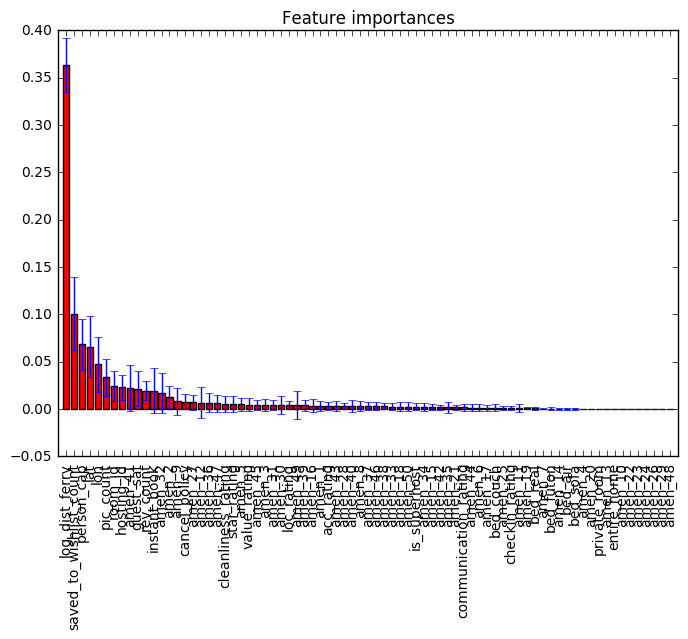

In [40]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [featureList[i] for i in indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

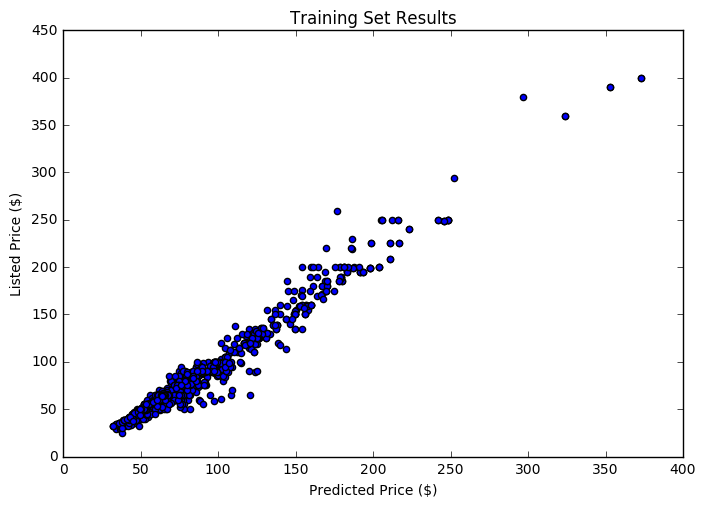

In [41]:
plt.scatter(df.ix[train_rows]['pred_price'],df.ix[train_rows]['price'])
plt.title('Training Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Listed Price ($)');

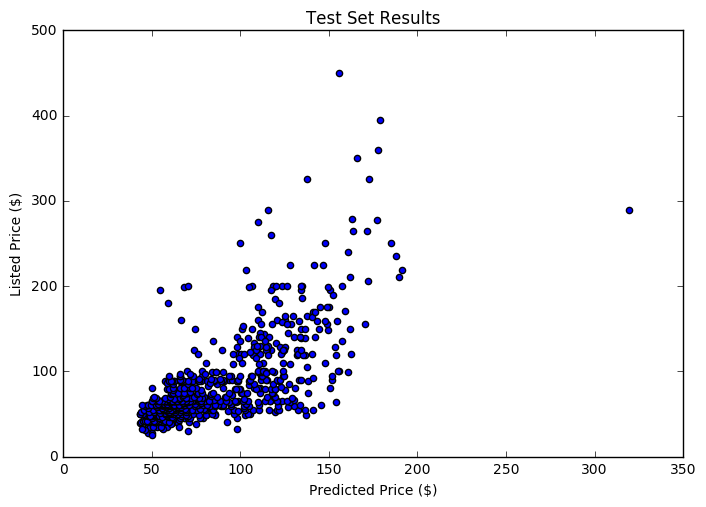

In [42]:
pred = forest.predict(df.drop(train_rows)[featureList])
plt.scatter(pred,df_test['price'])
plt.title('Test Set Results')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Listed Price ($)');

In [43]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [44]:
dbname = 'airbnb_db'
username = 'brian'
pswd = ''
engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))
print('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))
print(engine.url)

postgresql://brian:@localhost/airbnb_db
postgresql://brian:@localhost/airbnb_db


In [ ]:
df.to_sql('city_table', engine, if_exists='replace')

In [18]:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)
# query:
sql_query = 'SELECT * from city_table;'

airbnb_data_from_sql = pd.read_sql_query(sql_query,con)